In [30]:
from py_functions import plot_training_history, focal_loss
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Data loading

In [31]:
# Load X data ========================
vst_min_max = pd.read_csv("InputTables/Input_TCGA-BEAT_top3000_vst_min_max.txt", 
                          sep="\t", header=0)
Fischer_vst_min_max = pd.read_csv("InputTables/Input_Fischer_top3000_vst_min_max_ComBat.txt", 
                                  sep="\t", header=0)
Fischer_vst_min_max.columns = Fischer_vst_min_max.columns.str.replace('.', '-', regex=False)

# Check if columns are identical
assert list(Fischer_vst_min_max.columns) == list(vst_min_max.columns), "Column names do not match!"

# Load y data ========================
TCGA_BEAT_labels_df = pd.read_csv("InputTables/TCGA_BEAT_labels_cohesin.txt", 
                                  sep="\t", header=0)
TCGA_BEAT_labels = TCGA_BEAT_labels_df['label'].tolist()

Fischer_labels_df = pd.read_csv("InputTables/Fischer_labels_cohesin.txt", 
                                sep="\t", header=0)
Fischer_labels = pd.Categorical(Fischer_labels_df['label'])

# Load partition indexes ========================
train_index = np.loadtxt("InputTables/Input_train_indexes.txt", dtype=int)

# Convert R's 1-based indices to 0-based indices
train_index = train_index - 1

# ======================== Split data ========================
y_train = pd.Categorical([TCGA_BEAT_labels[i] for i in train_index])
y_test = pd.Categorical([TCGA_BEAT_labels[i] for i in range(len(TCGA_BEAT_labels)) if i not in train_index])

x_train_vst_min_max = vst_min_max.iloc[train_index, :]

all_indices = np.arange(len(vst_min_max))
test_index = np.setdiff1d(all_indices, train_index)

x_test_vst_min_max = vst_min_max.iloc[test_index, :]


# Prepare data

In [32]:
# Convert categorical labels to integers
le = LabelEncoder()
le.classes_ = np.array(["wtAML", "cohesinAML"])
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Check mapping
for i, cls in enumerate(le.classes_):
    print(f"Class {cls}: {i}")

Class wtAML: 0
Class cohesinAML: 1


# Handle class imbalance 

In [33]:
smote = SMOTE(random_state=12345)
x_train_smote, y_train_smote = smote.fit_resample(x_train_vst_min_max, y_train_encoded)

# Build FCNN

In [34]:
model_dropout_03 = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_vst_min_max.shape[1],), name='hidden_layer_1'),
    Dropout(0.2, name='dropout_1'),
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    # Dense(64, activation='relu', name='hidden_layer_3'),
    # Dropout(0.2, name='dropout_3'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Define optimizer
optimizer = Adam(learning_rate=1e-5)

# Compile model
model_dropout_03.compile(optimizer=optimizer,
              loss=focal_loss(),
              metrics=['accuracy'])

# Show summary
model_dropout_03.summary()

/venv/cohANN/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,449 (1.50 MB)

 Trainable params: 392,449 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

# Define Early Stopping

In [35]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Train model

Set random seeds

In [36]:
random.seed(12345)
np.random.seed(12345)
tensorflow.random.set_seed(12345)

In [37]:
history = model_dropout_03.fit(
    x_train_smote,
    y_train_smote,
    validation_data=(x_test_vst_min_max, y_test_encoded),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5043 - loss: 0.0519 - val_accuracy: 0.4895 - val_loss: 0.0443
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5544 - loss: 0.0459 - val_accuracy: 0.5105 - val_loss: 0.0438
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5693 - loss: 0.0444 - val_accuracy: 0.6076 - val_loss: 0.0413
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 0.0425 - val_accuracy: 0.7089 - val_loss: 0.0392
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6226 - loss: 0.0408 - val_accuracy: 0.7300 - val_loss: 0.0381
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6130 - loss: 0.0410 - val_accuracy: 0.6793 - val_loss: 0.0399
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6343 - loss: 0.0399 - val_accuracy: 0.7637 - val_loss: 0.0370
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6695 - loss: 0.0385 - val_accuracy: 0.

# Evaluate the model


Test Accuracy: 0.9030
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

       wtAML       0.94      0.95      0.94       201
  cohesinAML       0.69      0.67      0.68        36

    accuracy                           0.90       237
   macro avg       0.81      0.81      0.81       237
weighted avg       0.90      0.90      0.90       237

Confusion Matrix:
[[190  11]
 [ 12  24]]


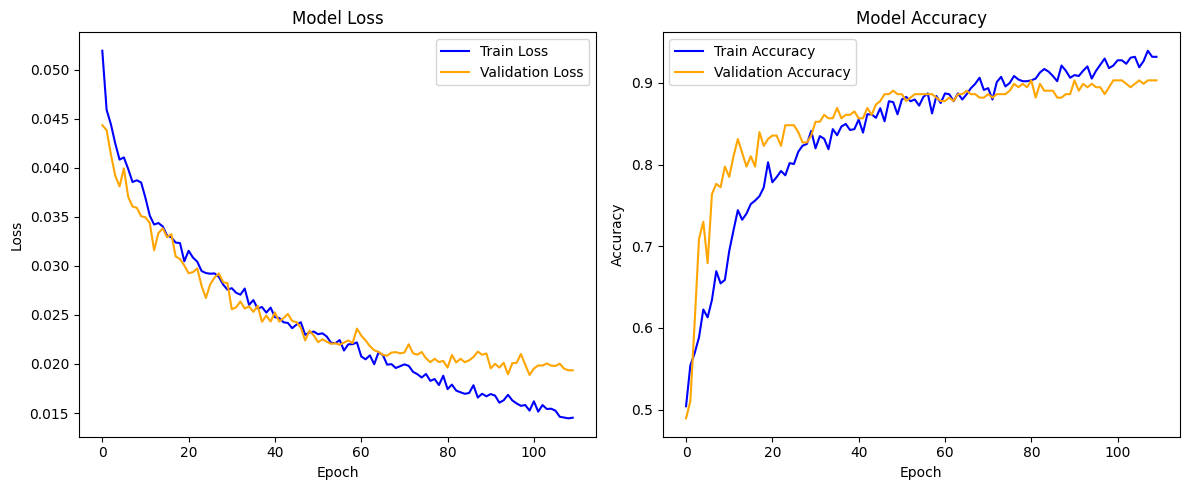

In [39]:
test_loss, test_acc = model_dropout_03.evaluate(x_test_vst_min_max, y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred_prob = model_dropout_03.predict(x_test_vst_min_max)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=['wtAML', 'cohesinAML']))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))
plot_training_history(history)